In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
H, W = 224, 224
BATCH_SIZE = 32
EPOCH = 50

In [3]:
image_paths = []
image_labels = []
normal_count = scc_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/'):
    for filename in filenames:
        if "bak" in filename: continue    #Ignore all images ending with .bak
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'normal' in filename:
            image_labels.append(0)
            normal_count += 1
        else:
            image_labels.append(1)
            scc_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Image count:", len(image_paths))
print("Normal count:", normal_count)
print("SCC count:", scc_count)
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_4343.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_3046.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_4472.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0352.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_3267.jpg'] 

[0, 0, 1, 1, 0] 

Image count: 10000
Normal count: 5000
SCC count: 5000
Image size: (512, 512)
Image mode: RGB


In [4]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 7000
Validation size: 1500
Testing size: 1500


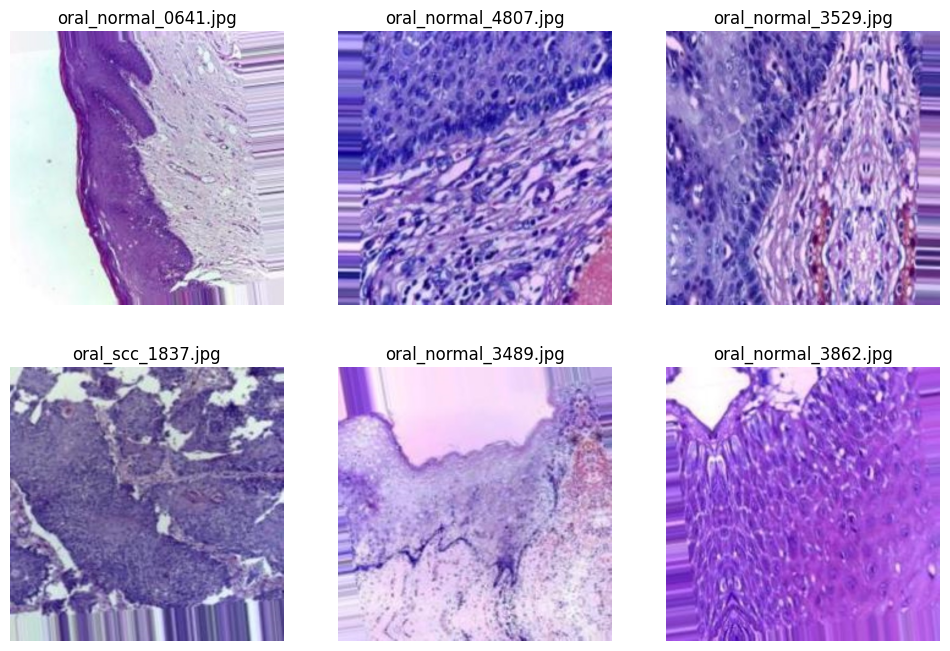

In [5]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [6]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 7000/7000 [01:50<00:00, 63.28it/s]

Mean: tensor([0.5520, 0.5136, 0.7283])
Std: tensor([0.1620, 0.1928, 0.1225])


In [7]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [10]:

EPOCH = 25                 # 第一階段的 Epoch 數量

best_model_path = "best_oral_cancer_model.pth"

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Loading ResNet50 model...")
model = models.resnet50(pretrained=True)

# 凍結所有層
for param in model.parameters():
    param.requires_grad = False

# 最後的分類層
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 2) # (normal, scc)

model = model.to(device)

# --- Training ---
print("\n--- Training  ---")

criterion = nn.CrossEntropyLoss()

# 優化器 
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

best_val_acc = 0.0

for epoch in range(EPOCH):
    model.train() 
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})


    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    print(f"Epoch {epoch+1}/{EPOCH} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    # 儲存最佳模型
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")

print("finished.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Loading ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s] 



--- Training  ---


Epoch 1/25 [Val]: 100%|██████████| 47/47 [00:27<00:00,  1.73it/s, loss=0.464]


Epoch 1/25 | Train Loss: 0.5551 Acc: 0.7141 | Val Loss: 0.5299 Acc: 0.7440
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7440


Epoch 2/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s, loss=0.353]


Epoch 2/25 | Train Loss: 0.4808 Acc: 0.7680 | Val Loss: 0.4394 Acc: 0.7900
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7900


Epoch 3/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s, loss=0.606]


Epoch 3/25 | Train Loss: 0.4682 Acc: 0.7766 | Val Loss: 0.4490 Acc: 0.7973
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7973


Epoch 4/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s, loss=0.575]


Epoch 4/25 | Train Loss: 0.4679 Acc: 0.7793 | Val Loss: 0.4783 Acc: 0.7840


Epoch 5/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.582]


Epoch 5/25 | Train Loss: 0.4304 Acc: 0.8016 | Val Loss: 0.4201 Acc: 0.7973


Epoch 6/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s, loss=0.303]


Epoch 6/25 | Train Loss: 0.4386 Acc: 0.7974 | Val Loss: 0.3939 Acc: 0.8213
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8213


Epoch 7/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s, loss=0.342]


Epoch 7/25 | Train Loss: 0.4148 Acc: 0.8089 | Val Loss: 0.3968 Acc: 0.8140


Epoch 8/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s, loss=0.565]


Epoch 8/25 | Train Loss: 0.4167 Acc: 0.8131 | Val Loss: 0.3908 Acc: 0.8213


Epoch 9/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.315]


Epoch 9/25 | Train Loss: 0.4153 Acc: 0.8106 | Val Loss: 0.3872 Acc: 0.8260
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8260


Epoch 10/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s, loss=0.318]


Epoch 10/25 | Train Loss: 0.4018 Acc: 0.8159 | Val Loss: 0.3756 Acc: 0.8360
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8360


Epoch 11/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.65it/s, loss=0.515]


Epoch 11/25 | Train Loss: 0.4013 Acc: 0.8176 | Val Loss: 0.3653 Acc: 0.8360


Epoch 12/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s, loss=0.445]


Epoch 12/25 | Train Loss: 0.4133 Acc: 0.8120 | Val Loss: 0.3646 Acc: 0.8333


Epoch 13/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s, loss=0.315]


Epoch 13/25 | Train Loss: 0.3826 Acc: 0.8267 | Val Loss: 0.3621 Acc: 0.8440
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8440


Epoch 14/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.457]


Epoch 14/25 | Train Loss: 0.4034 Acc: 0.8177 | Val Loss: 0.3798 Acc: 0.8307


Epoch 15/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.65it/s, loss=0.44] 


Epoch 15/25 | Train Loss: 0.3930 Acc: 0.8214 | Val Loss: 0.3564 Acc: 0.8407


Epoch 16/25 [Val]: 100%|██████████| 47/47 [00:13<00:00,  3.57it/s, loss=0.456]


Epoch 16/25 | Train Loss: 0.3936 Acc: 0.8189 | Val Loss: 0.3817 Acc: 0.8207


Epoch 17/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s, loss=0.238]


Epoch 17/25 | Train Loss: 0.4146 Acc: 0.8124 | Val Loss: 0.3954 Acc: 0.8293


Epoch 18/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s, loss=0.301]


Epoch 18/25 | Train Loss: 0.3760 Acc: 0.8297 | Val Loss: 0.3770 Acc: 0.8240


Epoch 19/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s, loss=0.317]


Epoch 19/25 | Train Loss: 0.3749 Acc: 0.8357 | Val Loss: 0.4354 Acc: 0.8087


Epoch 20/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s, loss=0.237]


Epoch 20/25 | Train Loss: 0.3910 Acc: 0.8240 | Val Loss: 0.3594 Acc: 0.8353


Epoch 21/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s, loss=0.393]


Epoch 21/25 | Train Loss: 0.3605 Acc: 0.8413 | Val Loss: 0.3388 Acc: 0.8533
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8533


Epoch 22/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s, loss=0.316]


Epoch 22/25 | Train Loss: 0.3653 Acc: 0.8383 | Val Loss: 0.3371 Acc: 0.8580
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8580


Epoch 23/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s, loss=0.351]


Epoch 23/25 | Train Loss: 0.3642 Acc: 0.8366 | Val Loss: 0.3583 Acc: 0.8367


Epoch 24/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s, loss=0.329]


Epoch 24/25 | Train Loss: 0.3819 Acc: 0.8256 | Val Loss: 0.3335 Acc: 0.8507


Epoch 25/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s, loss=0.233]

Epoch 25/25 | Train Loss: 0.3607 Acc: 0.8370 | Val Loss: 0.3442 Acc: 0.8413
finished.


In [11]:
# 模型微調 
print("\n--- Fine-Tuning ---")

NUM_FINETUNE_EPOCHS = 20   # 第二階段的 Epoch 數量

# 載入第一階段的最佳模型
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from Phase 1 with Val Acc: {best_val_acc:.4f}")

# 解凍所有層
for param in model.parameters():
    param.requires_grad = True

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-5) # 學習率 0.00001

best_finetune_acc = best_val_acc 

for epoch in range(NUM_FINETUNE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Finetune Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)


    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Finetune Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    print(f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    # 儲存的最佳模型
    if epoch_val_acc > best_finetune_acc:
        best_finetune_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path) # 覆蓋掉舊的最佳模型
        print(f"New BEST model saved (Fine-Tuning) to {best_model_path} with Val Acc: {best_finetune_acc:.4f}")

print(" Fine-tuning finished.")




--- Fine-Tuning ---
Loaded best model from Phase 1 with Val Acc: 0.8580


Epoch 1/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.81it/s, loss=0.344] 


Epoch 1/20 | Train Loss: 0.2749 Acc: 0.8824 | Val Loss: 0.2196 Acc: 0.9127
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9127


Epoch 2/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s, loss=0.238] 


Epoch 2/20 | Train Loss: 0.1747 Acc: 0.9299 | Val Loss: 0.1447 Acc: 0.9447
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9447


Epoch 3/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s, loss=0.129]  


Epoch 3/20 | Train Loss: 0.1309 Acc: 0.9477 | Val Loss: 0.0971 Acc: 0.9587
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9587


Epoch 4/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s, loss=0.0197] 


Epoch 4/20 | Train Loss: 0.0995 Acc: 0.9641 | Val Loss: 0.0887 Acc: 0.9653
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9653


Epoch 5/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s, loss=0.101]  


Epoch 5/20 | Train Loss: 0.0815 Acc: 0.9680 | Val Loss: 0.0736 Acc: 0.9707
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9707


Epoch 6/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s, loss=0.0595] 


Epoch 6/20 | Train Loss: 0.0660 Acc: 0.9753 | Val Loss: 0.0697 Acc: 0.9753
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9753


Epoch 7/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s, loss=0.0177] 


Epoch 7/20 | Train Loss: 0.0550 Acc: 0.9787 | Val Loss: 0.0559 Acc: 0.9793
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9793


Epoch 8/20 [Finetune Val]: 100%|██████████| 47/47 [00:13<00:00,  3.57it/s, loss=0.0429] 


Epoch 8/20 | Train Loss: 0.0566 Acc: 0.9777 | Val Loss: 0.0548 Acc: 0.9760


Epoch 9/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s, loss=0.000962]


Epoch 9/20 | Train Loss: 0.0388 Acc: 0.9851 | Val Loss: 0.0584 Acc: 0.9773


Epoch 10/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s, loss=0.117]   


Epoch 10/20 | Train Loss: 0.0437 Acc: 0.9856 | Val Loss: 0.0467 Acc: 0.9807
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9807


Epoch 11/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s, loss=0.00479] 


Epoch 11/20 | Train Loss: 0.0352 Acc: 0.9864 | Val Loss: 0.0510 Acc: 0.9840
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9840


Epoch 12/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.81it/s, loss=0.0798]  


Epoch 12/20 | Train Loss: 0.0396 Acc: 0.9841 | Val Loss: 0.0348 Acc: 0.9853
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9853


Epoch 13/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s, loss=0.139]   


Epoch 13/20 | Train Loss: 0.0298 Acc: 0.9891 | Val Loss: 0.0397 Acc: 0.9853


Epoch 14/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s, loss=0.000641]


Epoch 14/20 | Train Loss: 0.0312 Acc: 0.9873 | Val Loss: 0.0408 Acc: 0.9847


Epoch 15/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s, loss=0.00975]


Epoch 15/20 | Train Loss: 0.0295 Acc: 0.9887 | Val Loss: 0.0385 Acc: 0.9800


Epoch 16/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s, loss=0.000293]


Epoch 16/20 | Train Loss: 0.0296 Acc: 0.9879 | Val Loss: 0.0354 Acc: 0.9833


Epoch 17/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.83it/s, loss=0.0993]  


Epoch 17/20 | Train Loss: 0.0275 Acc: 0.9884 | Val Loss: 0.0298 Acc: 0.9880
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9880


Epoch 18/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s, loss=0.0343]  


Epoch 18/20 | Train Loss: 0.0312 Acc: 0.9883 | Val Loss: 0.0365 Acc: 0.9853


Epoch 19/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s, loss=0.000321]


Epoch 19/20 | Train Loss: 0.0238 Acc: 0.9903 | Val Loss: 0.0226 Acc: 0.9907
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9907


Epoch 20/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s, loss=0.0576]  

Epoch 20/20 | Train Loss: 0.0233 Acc: 0.9907 | Val Loss: 0.0400 Acc: 0.9820
 Fine-tuning finished.



--- Final Testing & Metrics Calculation ---


Testing: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


 Final Results
Accuracy  : 0.9900
Precision : 0.9946
Recall    : 0.9853
F1 Score  : 0.9900
------------------------------

 Report 
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       750
         SCC       0.99      0.99      0.99       750

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



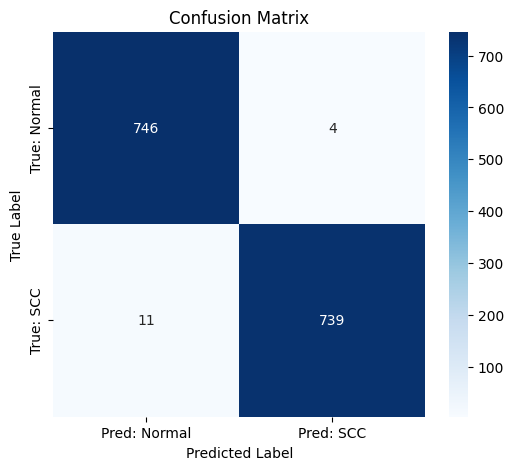

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n--- Final Testing & Metrics Calculation ---")

model.load_state_dict(torch.load(best_model_path))

model.eval()
model.to(device)


all_labels = []
all_preds = []


with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print("\n" + "="*30)
print(f" Final Results")
print("="*30)
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("-" * 30)


print("\n Report ")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'SCC']))


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Normal', 'Pred: SCC'],
            yticklabels=['True: Normal', 'True: SCC'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()